In [6]:
library(repr)
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [4]:
data <- read_csv("data/OnlineNewsPopularity.csv")

Parsed with column specification:
cols(
  .default = col_double(),
  url = col_character()
)

See spec(...) for full column specifications.



In [5]:
named_data <- data %>%
    rename(
        monday = weekday_is_monday,
        tuesday = weekday_is_tuesday,
        wednesday = weekday_is_wednesday,
        thursday = weekday_is_thursday,
        friday = weekday_is_friday,
        saturday = weekday_is_saturday,
        sunday = weekday_is_sunday,
        lifestyle = data_channel_is_lifestyle,
        entertainment =  data_channel_is_entertainment,
        business = data_channel_is_bus,
        society_and_medicine =  data_channel_is_socmed,
        technology =  data_channel_is_tech,
        world =  data_channel_is_world
    )
#It didn't work when all in one pipe, I have no idea why. This seems to work though
tidy_data <- named_data %>%
    pivot_longer(cols =  lifestyle : world, 
                 names_to = 'Genre', 
                 values_to = 'Genre_Present') %>%
    pivot_longer(cols =   monday:sunday, 
                 names_to = 'Day_Of_Week', 
                 values_to = 'Day_Present') %>%
    filter(Genre_Present == 1) %>%
    filter(Day_Present == 1) %>%
    select(Genre, Day_Of_Week, shares)

head(tidy_data)

Genre,Day_Of_Week,shares
<chr>,<chr>,<dbl>
entertainment,monday,593
business,monday,711
business,monday,1500
entertainment,monday,1200
technology,monday,505
technology,monday,855


`summarise()` regrouping output by 'Genre' (override with `.groups` argument)



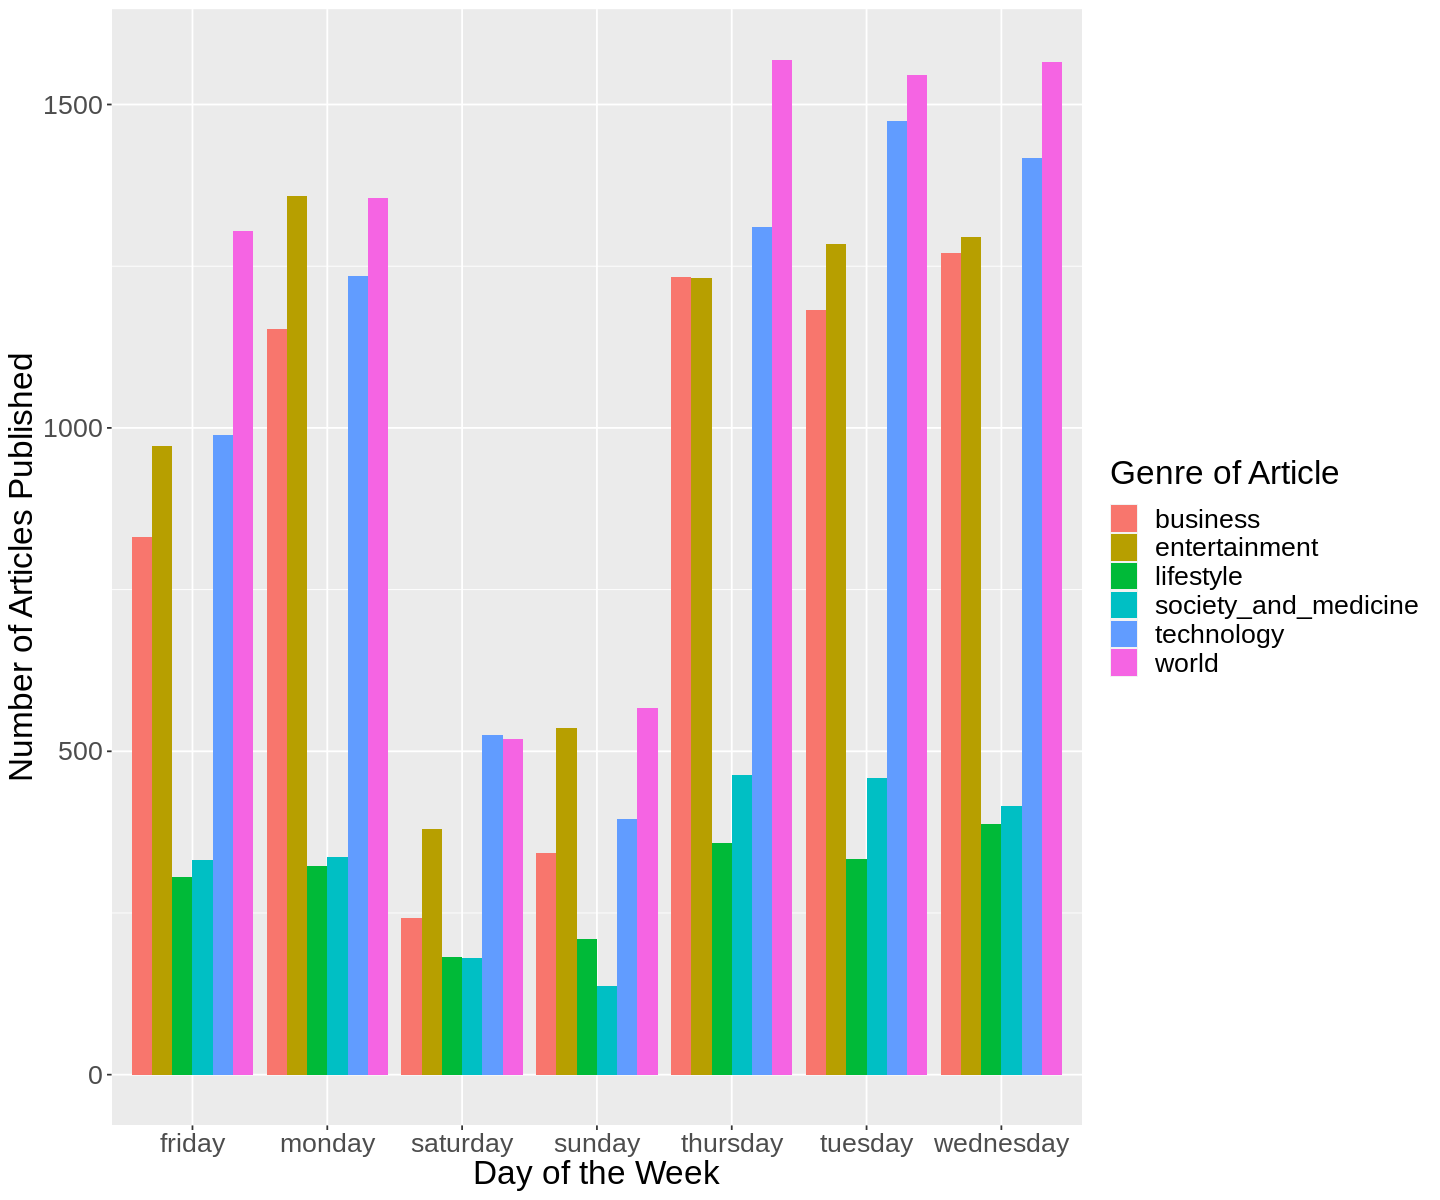

In [10]:
publish_data <- tidy_data %>%
    group_by(Genre, Day_Of_Week) %>%
    summarize(n = n())


options(repr.plot.width = 12, repr.plot.height = 10)
publish_plot <- publish_data %>%
    ggplot(aes(x = Day_Of_Week, y = n, fill = Genre)) + 
    geom_bar(stat = 'identity', position = "dodge") +
    xlab("Day of the Week") +
    ylab("Number of Articles Published") +
    labs(fill = "Genre of Article") +
    theme(text = element_text(size = 20))

publish_plot

In [11]:
share_data_avg <- tidy_data %>%
    group_by(Day_Of_Week, Genre) %>%
    summarize(n = n(), Average_Shares_Per_Article = mean(shares)/n)

head(share_data_avg)

`summarise()` regrouping output by 'Day_Of_Week' (override with `.groups` argument)



Day_Of_Week,Genre,n,Average_Shares_Per_Article
<chr>,<chr>,<int>,<dbl>
friday,business,832,2.841070
friday,entertainment,972,3.087394
friday,lifestyle,305,9.920881
friday,society_and_medicine,332,12.086987
friday,technology,989,3.084745
friday,world,1305,1.707595


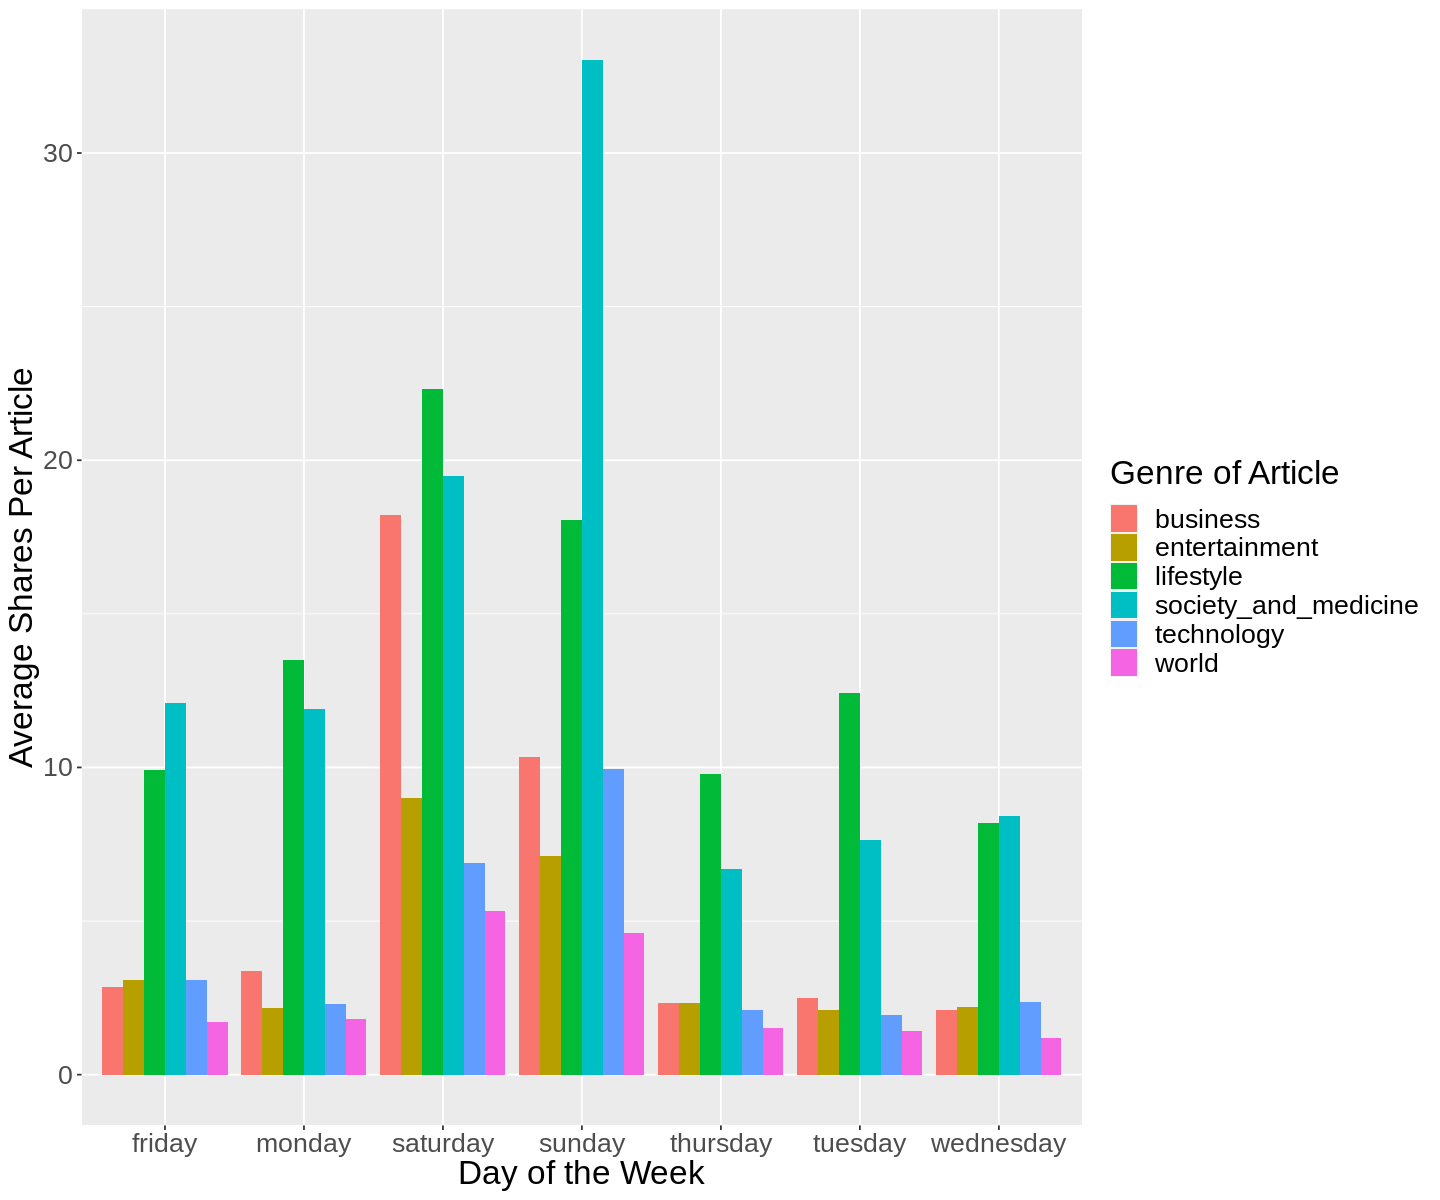

In [12]:



options(repr.plot.width = 12, repr.plot.height = 10)
share_plot <- share_data %>%
    ggplot(aes(x = Day_Of_Week, y = Average_Shares_Per_Article, fill = Genre)) + 
    geom_bar(stat = 'identity', position = "dodge") +
    xlab("Day of the Week") +
    ylab("Average Shares Per Article") +
    labs(fill = "Genre of Article") +
    theme(text = element_text(size = 20))

share_plot

In [14]:
share_data_totals <- tidy_data %>%
    group_by(Day_Of_Week, Genre) %>%
    summarize(n = n(), shares = sum(shares))

head(share_data_totals)

`summarise()` regrouping output by 'Day_Of_Week' (override with `.groups` argument)



Day_Of_Week,Genre,n,shares
<chr>,<chr>,<int>,<dbl>
friday,business,832,1966657
friday,entertainment,972,2916920
friday,lifestyle,305,922890
friday,society_and_medicine,332,1332276
friday,technology,989,3017254
friday,world,1305,2908077


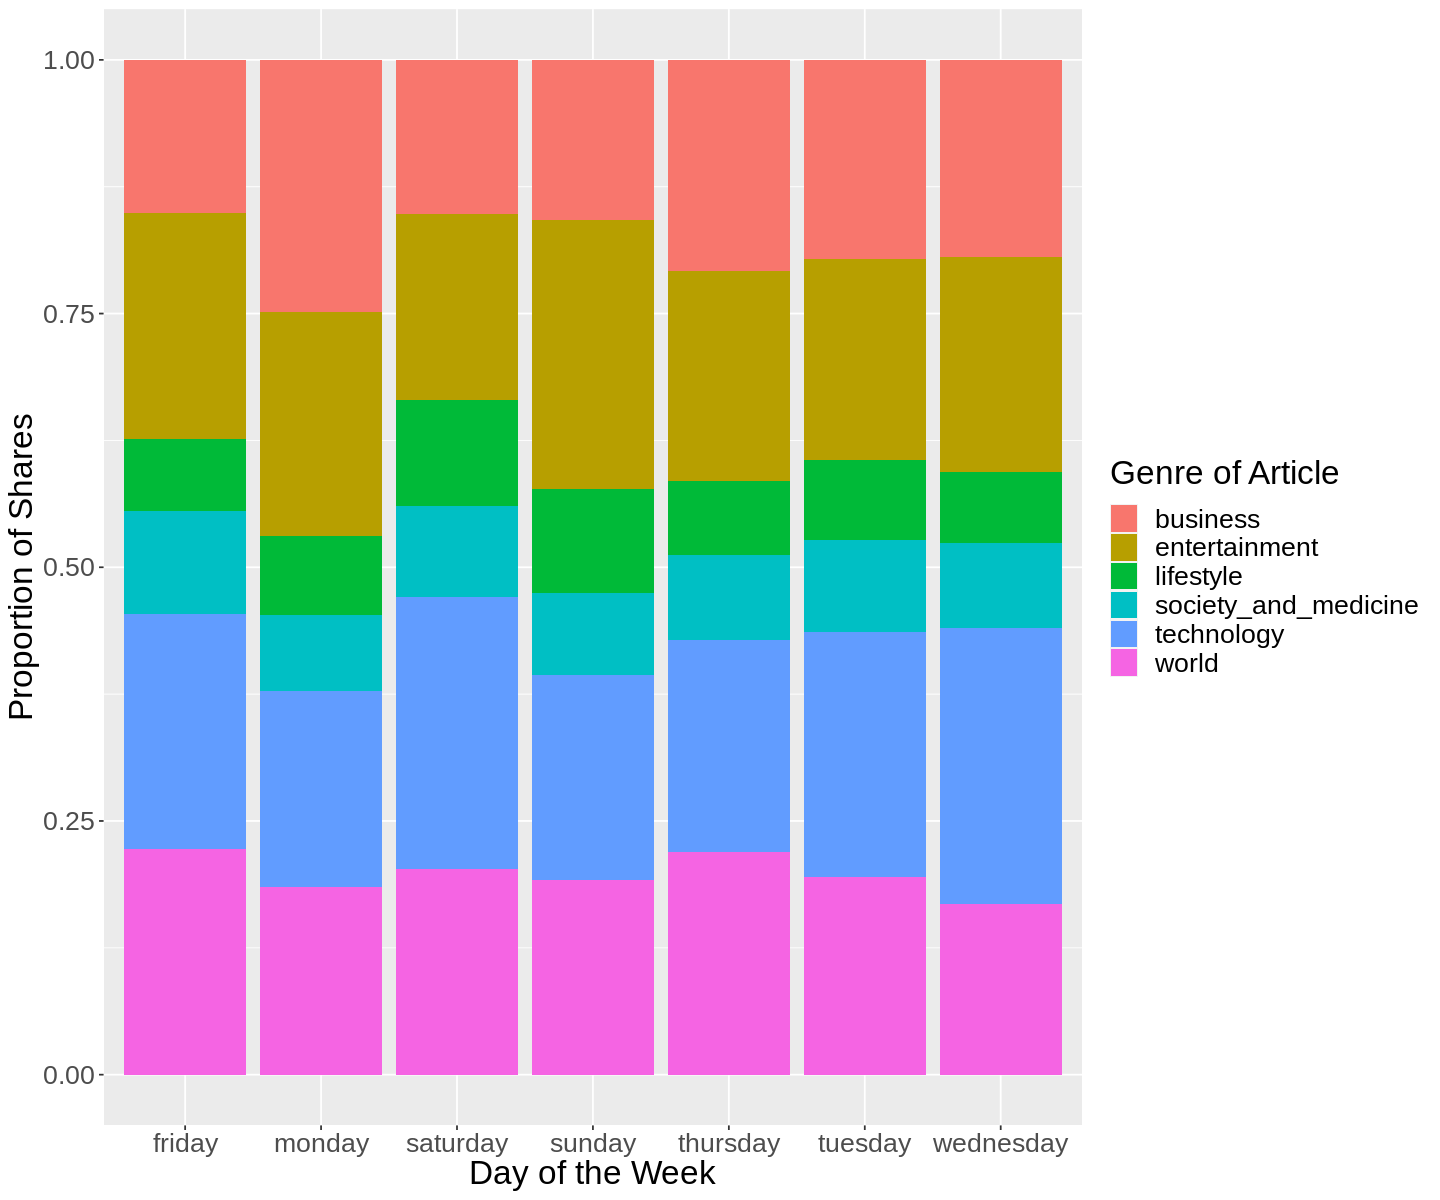

In [15]:



options(repr.plot.width = 12, repr.plot.height = 10)
share_plot_proportion <- share_data_totals %>%
    ggplot(aes(x = Day_Of_Week, y = shares, fill = Genre)) + 
    geom_bar(stat = 'identity', position = "fill") +
    xlab("Day of the Week") +
    ylab("Proportion of Shares") +
    labs(fill = "Genre of Article") +
    theme(text = element_text(size = 20))

share_plot_proportion

In [17]:
daily_totals <- share_data_totals %>%
    group_by(Day_Of_Week) %>%
    summarize(Total_Shares = sum(shares))
daily_totals

`summarise()` ungrouping output (override with `.groups` argument)



Day_Of_Week,Total_Shares
<chr>,<dbl>
friday,13064074
monday,18028340
saturday,7075560
sunday,7709981
thursday,17144651
tuesday,17619757
wednesday,17496296


In [27]:
share_daily_proportions <- share_data_totals %>%
    inner_join(daily_totals) %>%
    mutate(share_proportion = shares/Total_Shares)
head(share_daily_proportions)

Joining, by = "Day_Of_Week"



Day_Of_Week,Genre,n,shares,Total_Shares,share_proportion
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>
friday,business,832,1966657,13064074,0.15053933
friday,entertainment,972,2916920,13064074,0.22327798
friday,lifestyle,305,922890,13064074,0.07064335
friday,society_and_medicine,332,1332276,13064074,0.10198013
friday,technology,989,3017254,13064074,0.23095812
friday,world,1305,2908077,13064074,0.22260108


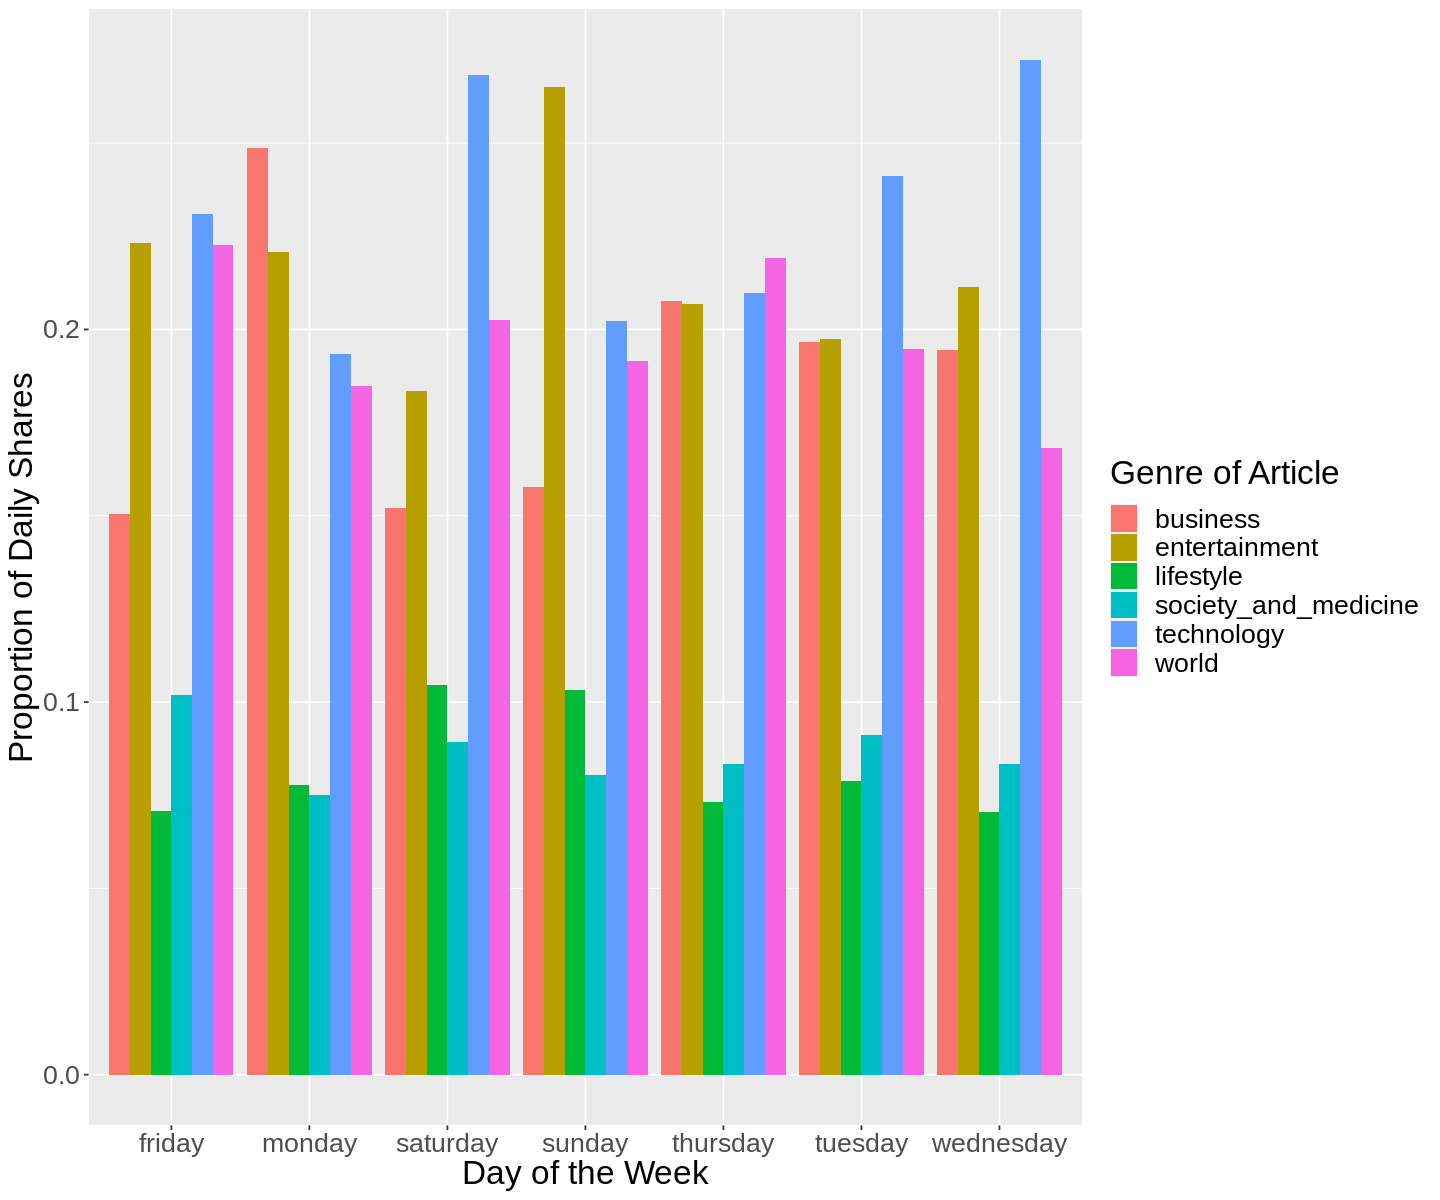

In [28]:
options(repr.plot.width = 12, repr.plot.height = 10)
share_plot_proportioned <- share_daily_proportions %>%
    ggplot(aes(x = Day_Of_Week, y = share_proportion, fill = Genre)) + 
    geom_bar(stat = 'identity', position = "dodge") +
    xlab("Day of the Week") +
    ylab("Proportion of Daily Shares") +
    labs(fill = "Genre of Article") +
    theme(text = element_text(size = 20))

share_plot_proportioned